# 下載 MNIST 資料
---
首先，匯入 keras 和相關模組。

In [1]:
# 匯入 numpy 和 pandas 模組，numpy 是 python 的程式庫，支援維度陣列與矩陣運算。
# pandas 則提供檔案存取和數據操縱。
import numpy as np
import pandas as pd
# 從 keras.utils 匯入 to_categroical，因為後續要將 label 標籤 轉換成 one-hot encoding。
from tensorflow.keras.utils import to_categorical
# 設定 seed 可以讓每次產生隨機值時，都會有相同的輸出。(若使用GPU，則無法每次皆相同)
# 須改為學號末四碼
seed = 6059
np.random.seed(seed)

Keras 中已經提供許多機器學習常用的數據集，包括波士頓房地產數據、CIFAR10、和這次範例要使用的手寫數據集。所以先從 keras 匯入 MNIST。

第一次執行 mnist.load_data() ，程式會檢查目錄是否已經有檔案，如果沒有就會自動下載，所以第一次可能都會比較久。之後再次執行時不用再次下載就會快速很多。


In [2]:
from tensorflow.keras.datasets import mnist,cifar10
(X_train_image, y_train_label),\
    (X_test_image, y_test_label) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


先來看看 MNIST 資料數據集的筆數，還有訓練資料的組成。

可以看到 train 訓練資料有 60000 筆，test 測試資料有 10000 筆。

訓練資料是由 images 和 labels 所組成共 60000 筆， images 是單色的數字影像，labels 是數字影像對應的真實值。

In [3]:
print('train data : ', len(X_train_image))
print('test data : ', len(X_test_image))

train data :  60000
test data :  10000


In [4]:
print('x_train_image : ', X_train_image.shape)
print('y_train_label : ', y_train_label.shape)

x_train_image :  (60000, 28, 28)
y_train_label :  (60000,)


# 建立 plot_image 函式來顯示數字影像
---
來看看剛剛匯入的手寫數字圖像。



In [5]:
import matplotlib.pyplot as plt
def plot_image(image):
    # 設定圖形顯示大小
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    # 使用 plt.imshow() 顯示圖像，傳入參數是 28 X 28 的圖形，
    # cmap 參數設定為 binary 以黑白灰階顯示
    plt.imshow(image, cmap = 'binary')
    # 開始繪圖
    plt.show()

傳入訓練集第一筆資料，來看看他的影像。

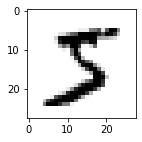

In [6]:
plot_image(X_train_image[0])

看看第一筆資料的 label

In [7]:
y_train_label[0]

5

# 查看多筆資料 images 與 labels
---
定義 plot_images_labels_prediction() 函式，傳入以下參數：images(數字影像)、labels(對應數字真實值)、prediction(預測結果)、idx(開始顯示影像的index)、num(要顯示的資料筆數，預設是10，不超過25)


In [8]:
def plot_images_labels_prediction(images, labels, prediction,
                                    idx, num = 10):
    # 設定顯示圖形大小
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    # 如果顯示筆數大於25 則將他設定為25 以避免錯誤
    if num > 25: num = 25
    # 使用 for 迴圈依序畫出 num 個數字圖形
    for i in range(0, num):
        ax = plt.subplot(5, 5, 1+i) # 建立 5 X 5 的 subgraph 子圖形
        ax.imshow(images[idx], cmap = 'binary') # 畫出 subgraph 子圖形
        title = "label=" + str(labels[idx]) # 設定子圖形 title 顯示標籤欄位
        if len(prediction) > 0: # 如果 prediction 有傳入值
            title += ",predict=" + str(prediction[idx]) # 將 prediction 加入 title
        ax.set_title(title, fontsize = 10) # 設定標題大小
        ax.set_xticks([]); ax.set_yticks([]) # 設定不顯示刻度
        idx += 1 # 讀取下一筆
    plt.show() # 開始畫圖

顯示訓練資料前 10 筆資料。不過目前還沒有預測結果所以傳入空 list ，由第 0 筆開始顯示至第 9 筆。

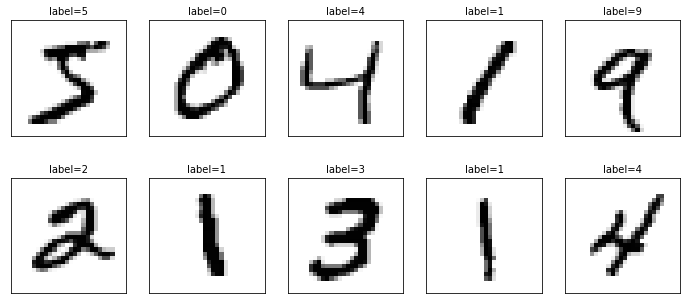

In [9]:
plot_images_labels_prediction(X_train_image, y_train_label, [], 0, 10)

查看 test 測試資料筆數，可以看到共10000筆資料。

In [10]:
print('x_test_image : ', X_test_image.shape)
print('y_test_label : ', y_test_label.shape)

x_test_image :  (10000, 28, 28)
y_test_label :  (10000,)


顯示測試資料前 10 筆資料圖形。

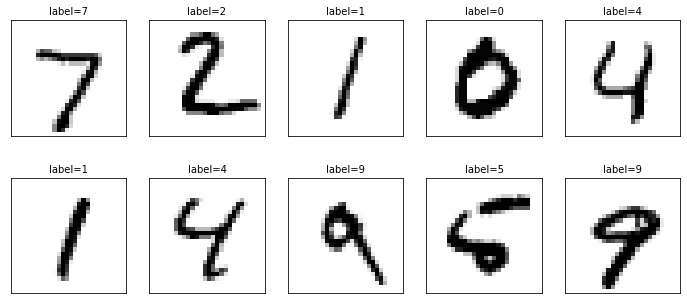

In [11]:
plot_images_labels_prediction(X_test_image, y_test_label, [], 0, 10)

# feature(數字影像的特徵值)資料預處理


In [12]:
X_Train = X_train_image.astype('float32')
X_Test = X_test_image.astype('float32')

查看一下每一個數字影像都變成 784 個 float 數字。

In [13]:
print('x_train : ', X_Train.shape)
print('x_test : ', X_Test.shape)

x_train :  (60000, 28, 28)
x_test :  (10000, 28, 28)


將 image 的數字標準化。

因為圖像的數字是介於 0 到 255，所以最簡單的方法就是除以 255。

In [14]:
X_Train_normalize = X_Train / 255
X_Test_normalize = X_Test / 255

# labels(數字影像對應真實值)資料預處理
---
先來查看一下訓練資料 label 標籤欄位前五筆資料，可以看到這是 0 ~ 9 的單一數字。

In [15]:
y_train_label[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

使用我們開頭匯入的 to_categorical函式，傳入 label 標籤，將他們轉換成 one-hot encoding。

In [16]:
y_TrainOneHot = to_categorical(y_train_label)
y_TestOneHot = to_categorical(y_test_label)

查看轉換過後的結果。

In [17]:
y_TrainOneHot[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

# 建立 MLP 模型
---
接下來建立我們的多層感知器模型，輸入層共有 (28*28) 個神經元，隱藏層 32 個神經元，最後輸出層共有 10 個神經元。

首先先匯入所需要的模組。

In [18]:
from tensorflow.keras import layers, metrics
from tensorflow.keras.layers import Dense,InputLayer,Flatten
from tensorflow.keras import models
import tensorflow as tf
tf.random.set_seed(seed)

建立 Sequential 一個線性堆疊模型，後續只要使用 model.add() 將個神經網路層依序加入模型即可。

In [19]:
model = models.Sequential()

建立輸入層
1.   設定輸入層神經元 維度為 (28,28,1)。
2.   把(28,28,1)攤平，變成一維

In [20]:
model.add(InputLayer(input_shape=(28,28,1)))
model.add(Flatten())

建立隱藏層。
1.   定義隱藏層神經元 32 個。
2.   設定激活函數為 sigmoid
。



In [21]:
model.add(Dense(256,  kernel_initializer = 'normal',activation = 'relu'))
model.add(Dense(256,  kernel_initializer = 'normal',activation = 'relu'))
# elu exponential gelu hard_sigmoid linear relu selu sigmoid softmax softplus softsign swish tanh

建立輸出層總共 10 個神經元，對應要分類的數字類別 0 ~ 9 。設定激活函數為 softmax ，這樣每一個神經元的輸出結果可視為預測每一個數字的機率。

In [22]:
model.add(Dense(10, kernel_initializer = 'normal', activation = 'softmax'))

來看看我們建好的模型的摘要。

In [23]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________
None


# 進行訓練
---
首先使用 compile ，對訓練模型進行設定。相關參數有：
1.   loss : 設定損失函數，這邊使用 BinaryCrossentropy。另外也還有很多不同的函數，可以到 keras 官網查詢，不同的模型和資料都有他們最適合的函數。
2.   optimizer : 設定優化方法，這邊使用 sgd 方法。同樣 keras 也提供很多種優化方法。
1.   metrics : 設定評估模型的方式是 accuracy 準確率。

In [24]:
loss_function = 'categorical_crossentropy' # CategoricalHinge BinaryCrossentropy BinaryFocalCrossentropy CategoricalCrossentropy 
optimize_function = 'adam' # Adadelta , Adagrad ,Adam ,Adamax ,FTRL ,Nadam ,RMSprop ,sgd
model.compile(loss = loss_function, optimizer = optimize_function,metrics = ['accuracy'])

開始訓練，過程都會儲存在 train_history 變數，其中的相關參數：
1.   設定 validation_split = 0.2 ，將訓練資料 80% 作為訓練，20% 作為驗證資料。
1.   設定 epochs 執行 10 次訓練週期。每一批次 batch_size 有 200 筆資料。
2.   verbose = 2，顯示訓練過程。

In [25]:
train_history = model.fit(x = X_Train_normalize, y = y_TrainOneHot,
                            validation_split = 0.2, epochs = 20, batch_size = 100,
                            verbose = 2)

Epoch 1/20
480/480 - 7s - loss: 0.3003 - accuracy: 0.9140 - val_loss: 0.1649 - val_accuracy: 0.9501 - 7s/epoch - 14ms/step
Epoch 2/20
480/480 - 1s - loss: 0.1135 - accuracy: 0.9660 - val_loss: 0.1077 - val_accuracy: 0.9682 - 1s/epoch - 3ms/step
Epoch 3/20
480/480 - 1s - loss: 0.0722 - accuracy: 0.9780 - val_loss: 0.0883 - val_accuracy: 0.9715 - 1s/epoch - 3ms/step
Epoch 4/20
480/480 - 1s - loss: 0.0500 - accuracy: 0.9844 - val_loss: 0.0934 - val_accuracy: 0.9747 - 1s/epoch - 3ms/step
Epoch 5/20
480/480 - 1s - loss: 0.0368 - accuracy: 0.9881 - val_loss: 0.0828 - val_accuracy: 0.9766 - 1s/epoch - 3ms/step
Epoch 6/20
480/480 - 1s - loss: 0.0263 - accuracy: 0.9915 - val_loss: 0.1038 - val_accuracy: 0.9742 - 1s/epoch - 3ms/step
Epoch 7/20
480/480 - 1s - loss: 0.0233 - accuracy: 0.9924 - val_loss: 0.0969 - val_accuracy: 0.9757 - 1s/epoch - 3ms/step
Epoch 8/20
480/480 - 1s - loss: 0.0209 - accuracy: 0.9933 - val_loss: 0.0939 - val_accuracy: 0.9747 - 1s/epoch - 3ms/step
Epoch 9/20
480/480 - 1s

建立函式顯示訓練過程，會將每一個訓練週期的 accuracy 和 loss 以圖表顯示出來。

In [26]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

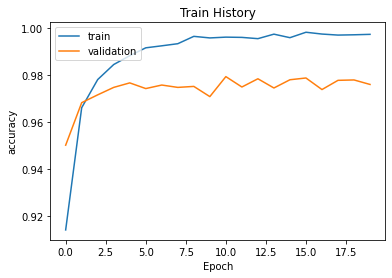

In [27]:
show_train_history(train_history, 'accuracy', 'val_accuracy')

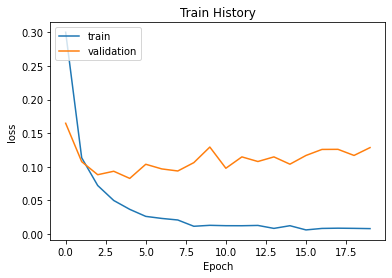

In [28]:
show_train_history(train_history, 'loss', 'val_loss')

# 以測試資料評估模型準確率
---


In [29]:
scores = model.evaluate(X_Test_normalize, y_TestOneHot)
print()
print('accuracy = ', scores[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.1306 - accuracy: 0.9761

accuracy =  0.9761000275611877


執行預測，將結果存到 prediction 中。

In [30]:
prediction = np.argmax(model.predict(X_Test), axis = -1)

313/313 [==============================] - 1s 2ms/step


In [31]:
prediction

array([7, 2, 1, ..., 4, 5, 6])

顯示 10 筆預測結果。

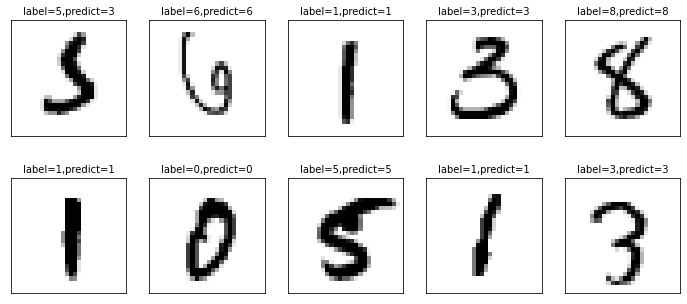

In [32]:
plot_images_labels_prediction(X_test_image, y_test_label, prediction, idx = 340)

In [33]:
y_test_label = y_test_label.reshape(10000)

混淆矩陣 

In [34]:
#使用 pandas 中的 crosstab 能夠很方便的建立混淆矩陣。
pd.crosstab(y_test_label, prediction, rownames = ['label'], colnames = ['predict'])

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,976,0,1,0,0,2,0,1,0,0
1,0,1127,3,0,0,2,2,0,1,0
2,7,5,1002,8,1,2,1,4,2,0
3,0,0,3,1000,0,4,0,1,0,2
4,3,1,1,1,954,0,6,1,1,14
5,3,0,0,11,1,870,3,1,1,2
6,8,3,0,0,2,6,939,0,0,0
7,0,5,7,9,0,0,0,1002,0,5
8,14,3,5,31,3,17,3,4,892,2


上傳圖片進行預測

Saving test_picture.jpg to test_picture (13).jpg
1/1 [==============================] - 0s 14ms/step


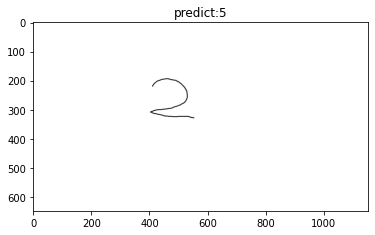

In [48]:
from google.colab import files
import cv2

test_label = [2]
#test_prediction = []
#從電腦上傳圖片
uploaded = files.upload()
filne_name = list(uploaded.keys())[0]
#讀取上傳的圖片為 numpy array
raw_test_im = plt.imread(filne_name)

processed_test_im = cv2.resize(raw_test_im, (28, 28))
processed_test_im = processed_test_im.astype('float32')
processed_test_im = processed_test_im / 255
test_prediction = np.argmax(model.predict(processed_test_im), axis = -1)
#plot_images_labels_prediction(uploaded, test_label, test_prediction, idx = 0 )
plt.title('predict:'+str(test_prediction[0]))
plt.imshow(raw_test_im)